In [2]:
import cv2
import numpy as np
from utils import show_images

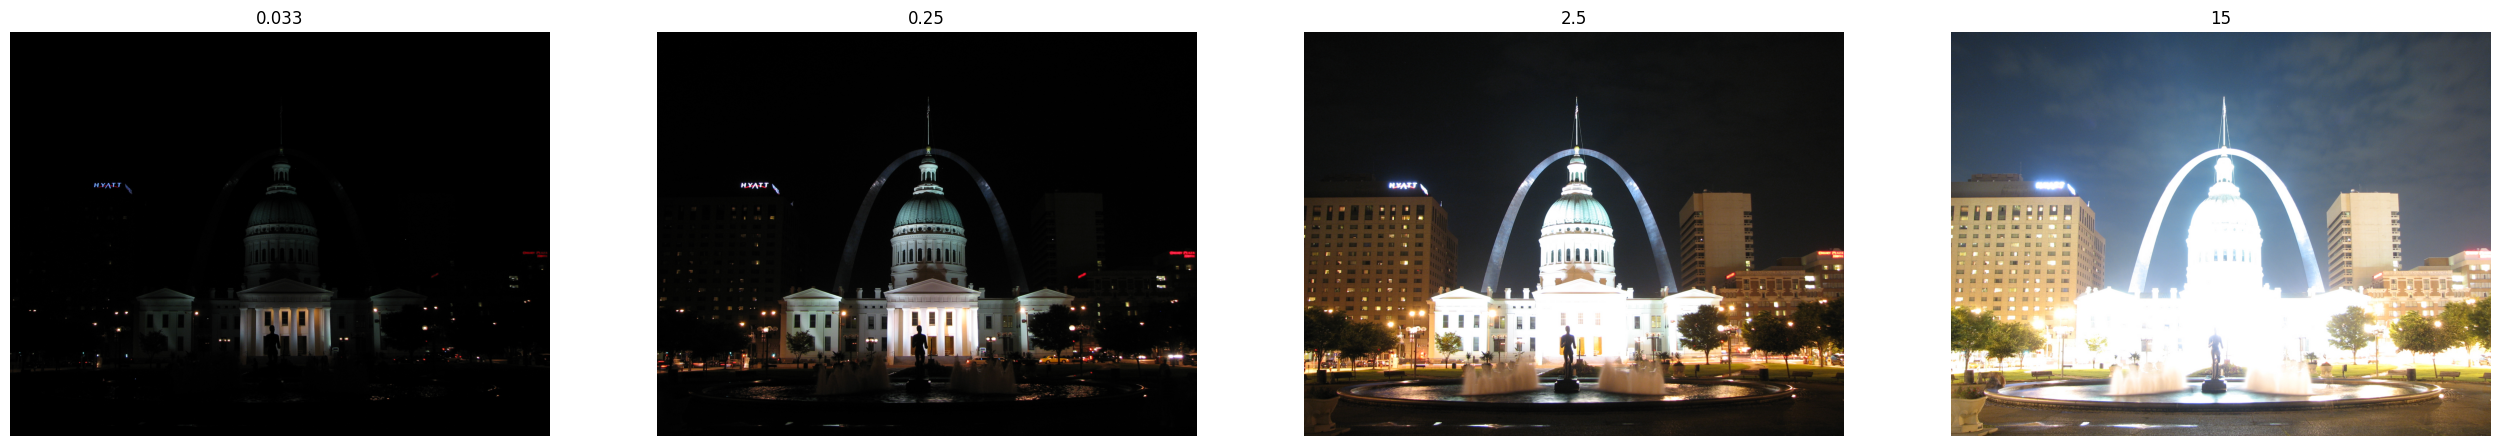

In [3]:
exp_times = [0.033, 0.25, 2.5, 15]

images = []
for now_exp in exp_times:
    images.append(cv2.imread(f'./image/hdr_imgs/img_{now_exp}.jpg', -1))

show_images([(now_exp, now_img) for now_exp, now_img in zip(exp_times, images)])

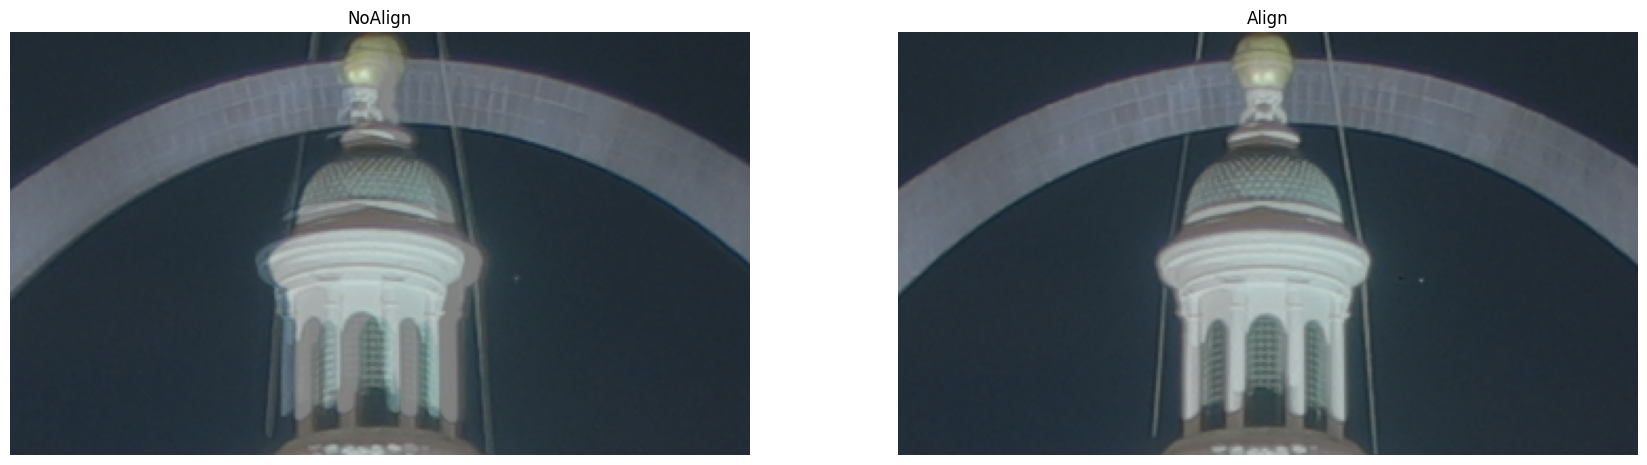

In [4]:
# 对齐和不对齐显示
result = []

mean_img = np.mean(images, axis=0).astype(np.uint8)
result.append(['NoAlign', np.copy(mean_img)[600:800, 1250:1600]])

alignMTB = cv2.createAlignMTB()
alignMTB.process(images, images)
mean_img = np.mean(images, axis=0).astype(np.uint8)
result.append(['Align', np.copy(mean_img)[600:800, 1250:1600]])

show_images(result)

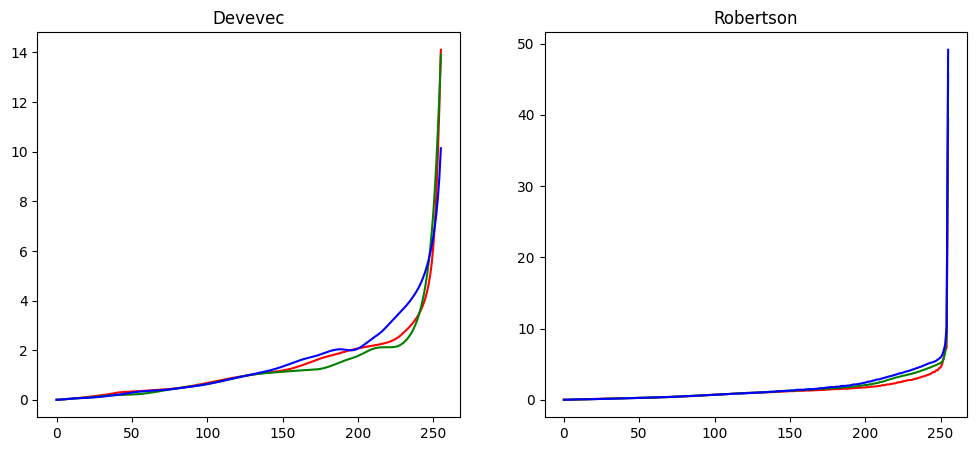

In [40]:
import matplotlib.pyplot as plt

# 获取相机的响应曲线 Camera Response Function (CRF)
result = []
    
exp_times = np.array(exp_times, dtype=np.float32)

# 返回值: (256, 1, 3)
calibrateDebevec = cv2.createCalibrateDebevec()
responseDebevec = calibrateDebevec.process(images, exp_times)

calibrateRobertson = cv2.createCalibrateRobertson()
responseRobertson = calibrateRobertson.process(images, exp_times)

# 画图
responses = [responseDebevec, responseRobertson]
titles = ['Devevec', 'Robertson']
fig, axes = plt.subplots(1, len(responses), figsize=(12, 5))
for i, response in enumerate(responses):
    axes[i].set_title(titles[i])
    axes[i].plot(response[..., 0], color='r')
    axes[i].plot(response[..., 1], color='g')
    axes[i].plot(response[..., 2], color='b')


In [14]:
# Merge images into an HDR linear image

# 只展示 Debevec；还有其他两个方法 Robertson, Mertens
mergeDebevec = cv2.createMergeDebevec()
hdrDebevec = mergeDebevec.process(images, exp_times, responseDebevec)

# # Save HDR image.
# cv2.imwrite("hdrDebevec.hdr", hdrDebevec)

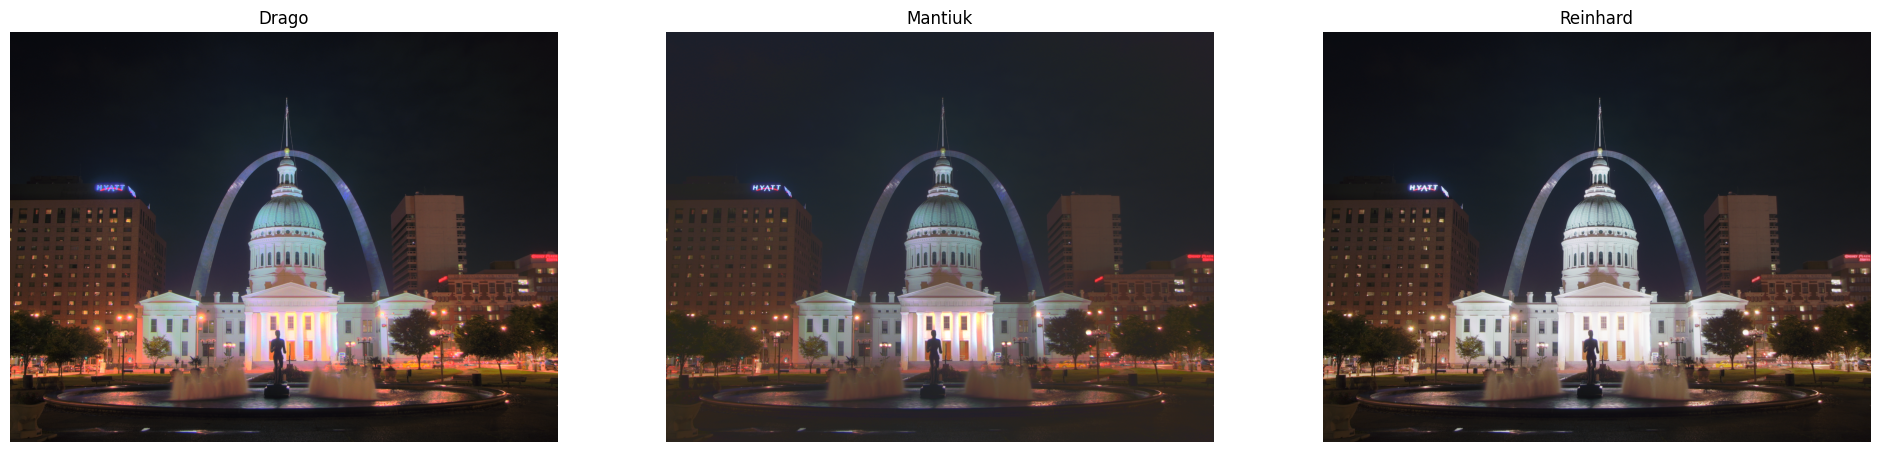

In [21]:
# Tonemap methods
# The final output is **multiplied by 3** just because it gave the most pleasing results

tonemapDrago = cv2.createTonemapDrago(1.0, 0.7)
ldrDrago = tonemapDrago.process(hdrDebevec)
ldrDrago = ldrDrago * 3
ldrDrago = (ldrDrago * 255).clip(0, 255).astype('uint8')

tonemapMantiuk = cv2.createTonemapMantiuk(2.2,0.85, 1.2)
ldrMantiuk = tonemapMantiuk.process(hdrDebevec)
ldrMantiuk = 3 * ldrMantiuk
ldrMantiuk = (ldrMantiuk * 255).clip(0, 255).astype('uint8')

tonemapReinhard = cv2.createTonemapReinhard(1.5, 0,0,0)
ldrReinhard = tonemapReinhard.process(hdrDebevec)
ldrReinhard = (ldrReinhard * 255).clip(0, 255).astype('uint8')

show_images([
    ('Drago', ldrDrago),
    ('Mantiuk', ldrMantiuk),
    ('Reinhard', ldrReinhard)
])